Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2185 - loss: 2.1841 - val_accuracy: 0.7300 - val_loss: 1.4032 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6173 - loss: 1.3576 - val_accuracy: 0.8300 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8245 - loss: 0.8836 - val_accuracy: 0.8550 - val_loss: 0.7195 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8402 - loss: 0.7394 - val_accuracy: 0.8550 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8461 - loss: 0.6444 - val_accuracy: 0.8650 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8753 - loss: 0.5117 - val_accuracy: 0.8900 - val_loss: 0.4981 - learning_rate: 0.0010
Epoch 7/10

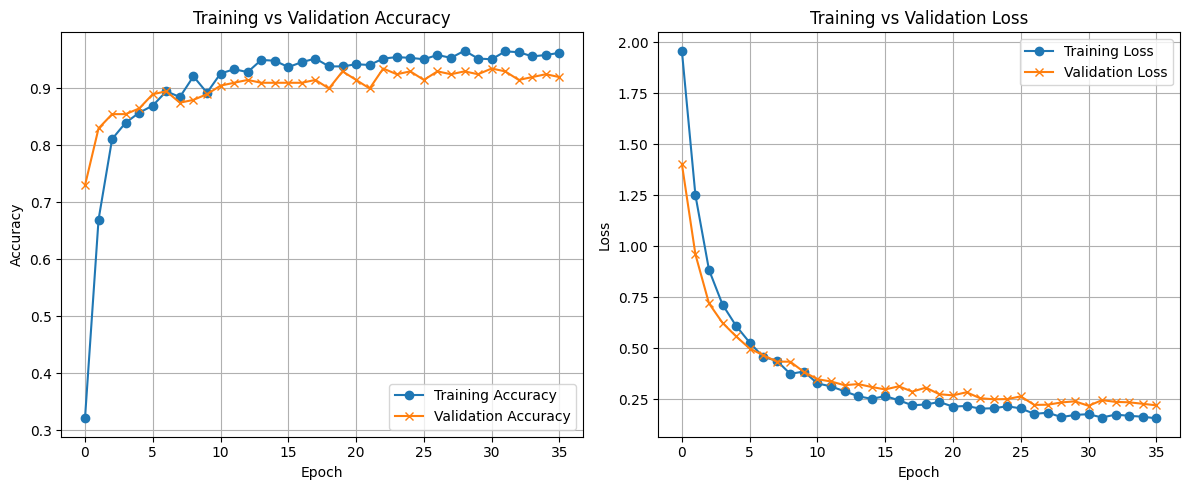

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step

📊 Validation Classification Report:
               precision    recall  f1-score   support

    Anthurium       1.00      0.95      0.97        20
Bougainvillea       0.87      1.00      0.93        20
Dama de noche       0.83      1.00      0.91        20
     Gumamela       1.00      1.00      1.00        20
    Rafflesia       1.00      1.00      1.00        20
        Rosal       0.86      0.95      0.90        20
   Sampaguita       0.94      0.80      0.86        20
       Santan       0.95      0.90      0.92        20
Waling-waling       0.95      0.90      0.92        20
  Ylang-ylang       1.00      0.85      0.92        20

     accuracy                           0.94       200
    macro avg       0.94      0.93      0.93       200
 weighted avg       0.94      0.94      0.93       200


📌 Validation Confusion Matrix:
[[19  1  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0

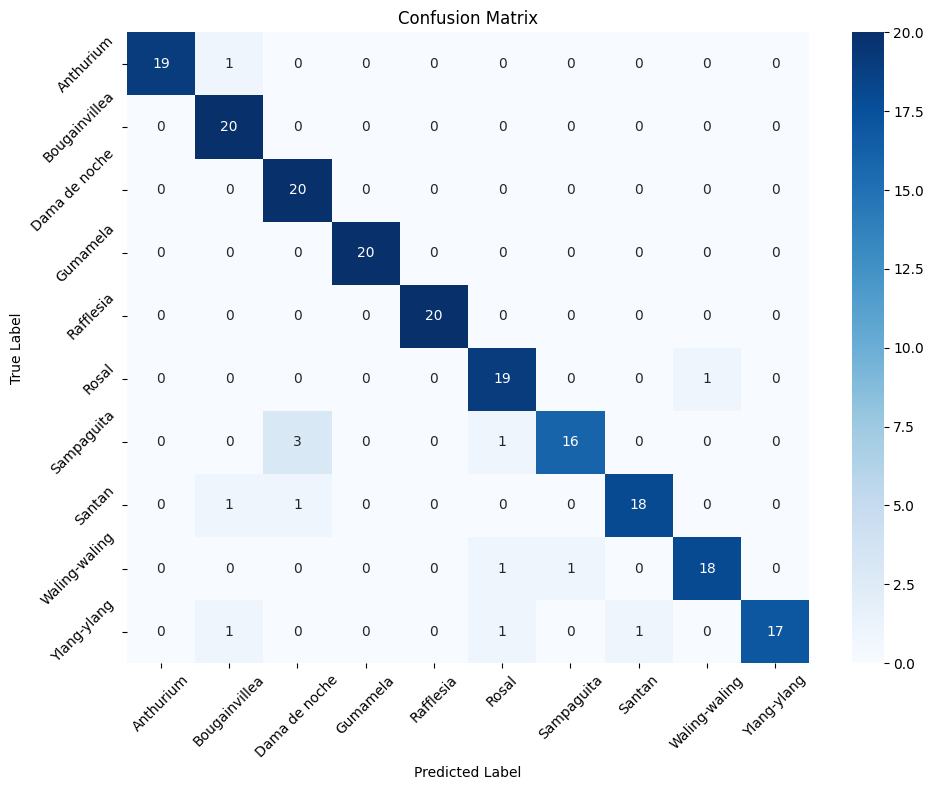

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf

# Paths
data_dir = "D:/Flowers"


# Image settings
img_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Build model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

model.save("efficientnetv2s_best_model.keras")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on validation set
val_generator.reset()
val_preds = model.predict(val_generator)
val_pred_labels = np.argmax(val_preds, axis=1)
val_true_labels = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Classification report
print("\n📊 Validation Classification Report:")
print(classification_report(val_true_labels, val_pred_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
print("\n📌 Validation Confusion Matrix:")
print(cm)

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Found 100 images belonging to 10 classes.


C:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 973ms/step - accuracy: 0.8551 - loss: 0.5322

✅ Test Loss: 0.4965
✅ Test Accuracy: 88.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step

📊 Test Classification Report:
               precision    recall  f1-score   support

    Anthurium       1.00      0.90      0.95        10
Bougainvillea       1.00      0.80      0.89        10
Dama de noche       1.00      0.80      0.89        10
     Gumamela       1.00      0.70      0.82        10
    Rafflesia       1.00      1.00      1.00        10
        Rosal       0.75      0.90      0.82        10
   Sampaguita       0.70      0.70      0.70        10
       Santan       1.00      1.00      1.00        10
Waling-waling       0.77      1.00      0.87        10
  Ylang-ylang       0.77      1.00      0.87        10

     accuracy                           0.88       100
    macro avg       0.90      0.88      0.88       100
 weighted avg       0.90      0.88      0.88       100


📌 Test Confusion Matrix:
[[ 9  0  0  0 

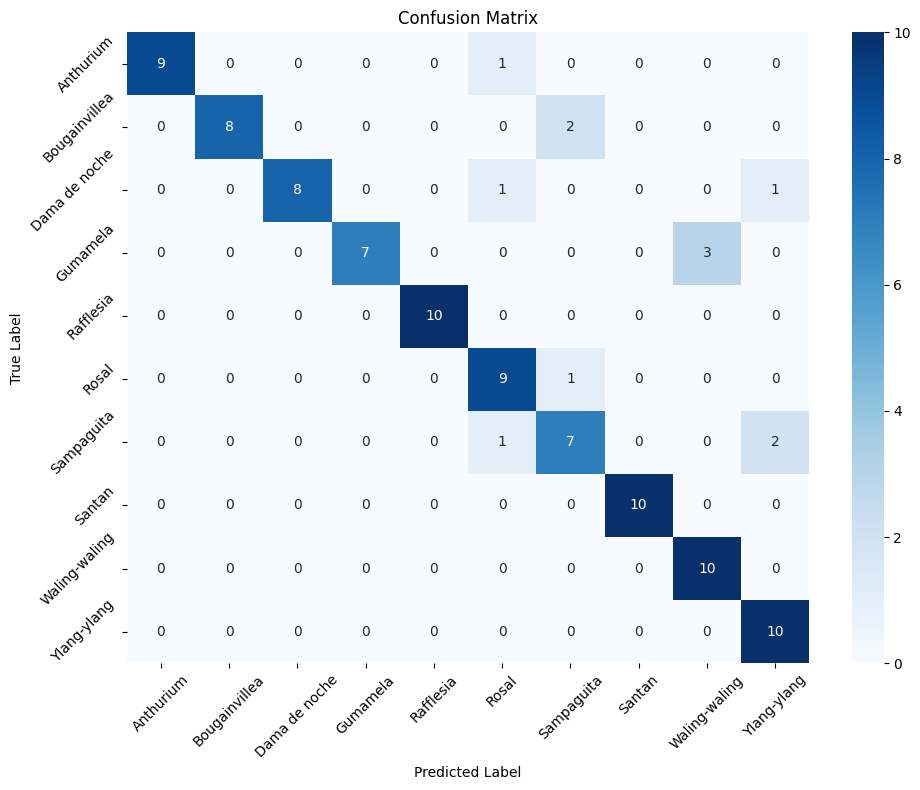

In [7]:
# Prepare test data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import preprocess_input

# Load the model
model = load_model("efficientnetv2s_best_model.keras")


img_size = (224, 224)
batch_size = 32
test_dir = "D:/test"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

# Predict and report
test_preds = model.predict(test_generator)
test_pred_labels = np.argmax(test_preds, axis=1)
test_true_labels = test_generator.classes
test_class_names = list(test_generator.class_indices.keys())

print("\n📊 Test Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_class_names))

cm_test = confusion_matrix(test_true_labels, test_pred_labels)
print("\n📌 Test Confusion Matrix:")
print(cm_test)

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_class_names,
            yticklabels=test_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()